## Model for outcome in the first 14 days 

In [39]:
# general
import pandas as pd
import numpy as np

from functions import modelling

# plot libarys
import seaborn as sns
import matplotlib.pyplot as plt

# Model preparation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_validate
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
 

# Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

# Model Metrics
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.metrics import f1_score, make_scorer # for modelling.py

# for merging the dataframes
import os, glob
import json

# further libarys
#import itertools
from sklearn.tree import export_graphviz

%matplotlib inline

In [5]:
df = pd.read_csv('data/IST_corrected_model.csv',  index_col= [0])

### Target for 14 days after first stroke

Target for the first model is survival (DDEAD == 'Y') within the first 14 days after the (first) stroke.


In [7]:
df.groupby("DDEAD").HOSPNUM.count()

DDEAD
N    15586
Y     1685
Name: HOSPNUM, dtype: int64

In [11]:
print(df.DDEAD.value_counts()[0] / df.shape[0] * 100)
print(df.DDEAD.value_counts()[1] / df.shape[0] * 100)

90.24376121822708
9.756238781772913


We have an imbalanced dataset - with a distribution of 90% alive and 10% dead patients after an ischaemic stroke.

In [ ]:
# deal with it later

### Modelling

In [44]:
# Select features
features = ['SEX', 'AGE', 'RSBP', 'STYPE']
X = df[features]

# Select target
y = df.DDEAD

In [48]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17271 entries, 0 to 19434
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SEX     17271 non-null  object
 1   AGE     17271 non-null  int64 
 2   RSBP    17271 non-null  int64 
 3   STYPE   17271 non-null  object
dtypes: int64(2), object(2)
memory usage: 674.6+ KB


In [69]:
# Split the data in test and training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)

### Preparation of Data Scaling and Category Encoding
Some models need scaling of numerical features and encoding of categorical features. The sklearn preprocessors are instantiated here and used where necessary in the data transformation step of each model.

In [91]:
# encoder for categories
onehot = OneHotEncoder(drop="first")

# scalers for numerical features
mms = MinMaxScaler()
ss = StandardScaler()

# Prepare list of numerical and categorical columns
num_cols = make_column_selector(dtype_include=np.number)
cat_cols = make_column_selector(dtype_include="object")

### Choosing a metric

We need to define a suitable metric for evaluating model performance. We saw earlier, that we have an imbalanced dataset. Therefore, we use F1-Score for model selection during grid search.

For our final model selection and parameter tuning, we want to be sure that we predict the survival only in case the patient really was alive after 14 days. Hence, we use precision as final model metric.

In [63]:
# Evaluation metric: F1-Score
f1 = make_scorer(f1_score , average='macro')

In [ ]:
#### Logistic Regression with Standard Scaler

In [92]:
# Define transformer
transformer = ColumnTransformer([
    ("scale", ss, num_cols),
    ("encode", onehot, cat_cols),
])

# Transform
X_train_trans = transformer.fit_transform(X_train)
X_test_trans = transformer.transform(X_test)

In [65]:
logreg_ss = LogisticRegression(max_iter=400)
m_logreg_ss = modelling.pred_eval_plot_model(X_train_trans, X_test_trans, y_train, y_test, logreg_ss)

--- MODEL PARAMETERS ----------


NameError: name 'json' is not defined

In [93]:
def pred_eval_plot_model(X_train, X_test, y_train, y_test, clf, cv=None):
    """Train a single model and print evaluation metrics.
    
    Args:
        X_train (pd.DataFrame, np.array): Features of the training set
        X_test (pd.DataFrame, np.array): Features of thee test set
        y_train (pd.Series, np.array): Target of the training set
        y_teset (pd.Seeries, np.array): Target of the test set
        clf (sklearn.base.BaseEstimator): Estimator to train and use
        cv (int, None): Number of cross-validations, default=None
    
    Returns:
        model (sklearn.base.BaseEstimator): The trained model
    """
    model = clf.fit(X_train, y_train)

    if cv:
        cv = cross_validate(m_rf, X_train, y_train, cv=5, verbose=5)
        print(f"Best cross-validated score: {cv['test_score'].mean()}")
    
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    

    print(f"--- F1-Score {'-'*10}")
    print(f1_score(y_test, y_pred, labels=np.unique(y_pred), pos_label= 'N'))
    print(f"--- CLASSIFICATION REPORT {'-'*10}")
    print(classification_report(y_test,y_pred))
    print(f"--- CONFUSION MATRIX {'-'*10}")
    print(confusion_matrix(y_test,y_pred))
    plot_confusion_matrix(model, X_test, y_test, display_labels=["alive", "deceased"])
    return model


--- F1-Score ----------
0.9486711300466625
--- CLASSIFICATION REPORT ----------
/Users/Nicole/Documents/Data_Science/neuefische/projects/Capstone/stroke/Capstone/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Nicole/Documents/Data_Science/neuefische/projects/Capstone/stroke/Capstone/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Nicole/Documents/Data_Science/neuefische/projects/Capstone/stroke/Capstone/.venv/lib/python3.8/site-packages/sklearn/metrics/_classificat

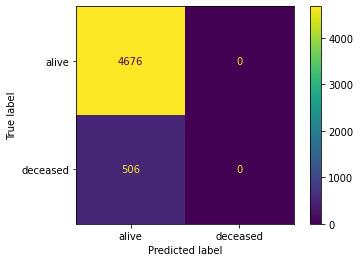

In [94]:
logreg_ss = LogisticRegression(max_iter=400)
m_logreg_ss = pred_eval_plot_model(X_train_trans, X_test_trans, y_train, y_test, logreg_ss)

In [70]:
#from collections import Counter
#print(Counter(y_train))
#Counter(y_test)

Counter({'N': 10910, 'Y': 1179})


Counter({'N': 4676, 'Y': 506})